# 1. Neural Network とは

## 1.1. はじめに

ChatGPT や画像生成などカジュアルにはAI とも呼ばれるこれらは,正式には**機械学習**(Machine Learning, ML)と呼ばれる技術です.
機械学習と聞くと比較的最近耳にするようになった印象もあるかもしれませんが, 実際には結構古い技術です.
実はみなさんも大学生の時分に触れていて, **fitting**という呼び方で馴染みがあるんじゃないでしょうか.

近年ではありとあらゆるところに機械学習が使われ,技術としても多種多様に見えますが, 根幹の技術は全てただのfittingです.
機械学習の話はイメージしにくいのが難点ですが, 単純なfittingで置き換えて考えるとかなり理解しやすくなります.
どんな機械学習の話もfittingとして実感できるようにする, というのがこのチュートリアルの目標です.

特にこの章ではfitting として解釈することに重きを置くため, 具体的にfitting を行う最適化のコードは一切実装しません.
`pytorch` を使って実際に最適化を行うsample code をお求めの方は<del>[2.Optimization]()</del> (work in progress) を参照してください.

## 1.2. Fitting の概観

Fitting の詳細な技術はここでは無視して, 用語の定義と大まかな流れを確認します.

### 1.2.1 Fitting の目的

入力の集合$X$ から出力の集合$Y$ への写像を解析的な形で得ることが目的です.
ここで「解析的」という表現は「数式で表現できて,やろうと思えば局所的に微積分が可能」という意味で雑に使っています.
解析的な写像と解析的ではない写像の例を挙げます.

> **_NOTE_** <details close><summary>解析的な写像と解析的ではない写像の例</summary>
> 
> - 解析的な写像
>   - いわゆる普通の関数たち
>     - $f(x) = x^2 + 3x + 1$
>     - $g(x) = \sin(x)$
>     - $h(x) = (f \circ g)(x)$
> - 解析的でない写像
>     - 逐次計算で出るようなやつやら,手順踏めば解析的な形で究極的には出せそうだけどアルゴリズムの内部が見えないせいでわからない(シミュレーションとか)
>     - sort やらはそうだけど,混乱を避けるためにもなるべくフェアに連続写像で例示したい
> 
> </details>

### 1.2.2 用語の定義

- 入力集合 $X$
- 出力集合 $Y$
- 目的関数 $f: X \to Y$
  - Fitting によって再現しようとしている, $X$と$Y$の間の写像
  - Fitting は一般に目的関数の具体的な形や表現が分からない状態で行います.
  - もっというと, 目的関数は解析的であるか否かもわからない状態でも行いえます.
- Fitting 関数 $\hat{f}: \Theta \to (X \to Y)$
  - パラメータとして具体的な値を与えると, 目的関数を近似する関数を返す写像.
  - パラメータ集合$\Theta$
    - 多くの場合 $\Theta \sub \mathbb{R}^n$ です.
  > **_NOTE_** <details close><summary> 例: 線形近似の場合</summary>
  > - 入力集合 $X = \mathbb{R}$,
  > - 入力集合 $Y = \mathbb{R}$
  > - パラメータ集合 $\Theta = \mathbb{R}^2$
  > - Fitting関数
  >   - $\hat{f}(x \mid {\theta}) = \theta_1 x + \theta_2$
  > </details>

- データセット $D = \{(x_i, y_i)\}_{i=1}^N ~ (x_i \in X, y_i \in Y)$
  - $X$の要素$x_i$と, 目的関数$f$ によって関連づけられた$Y$の要素$y_i = f(x_i)$の組の集合
    - 厳密には$y_i = f(x_i) + \epsilon_i$ の形で, 誤差$\epsilon_i$も考慮した形で考えることが多いです.
  - $N$ はデータセット内のサンプルの数

### 1.2.3 Fitting の流れ

目的関数がおおよそ一次関数の場合を例に、一般的なfitting の流れをおさらいします。

0. Given: $D = \{(x_0, y_0), (x_1, y_1), \dots, (x_n, y_n)\}$

> <details close><summary>Table</summary>
> 
> |  i |          x |          y |
> |---:|-----------:|-----------:|
> |  0 | -1         | -3.46875   |
> |  1 | -0.894737  | -3.3587    |
> |  2 | -0.789474  | -3.18168   |
> |  3 | -0.684211  | -2.80816   |
> |  4 | -0.578947  | -2.57535   |
> |  5 | -0.473684  | -2.59838   |
> |  6 | -0.368421  | -2.034     |
> |  7 | -0.263158  | -2.12891   |
> |  8 | -0.157895  | -1.76289   |
> |  9 | -0.0526316 | -1.55701   |
> | 10 |  0.0526316 | -1.30737   |
> | 11 |  0.157895  | -1.14899   |
> | 12 |  0.263158  | -0.999317  |
> | 13 |  0.368421  | -0.695888  |
> | 14 |  0.473684  | -0.606254  |
> | 15 |  0.578947  | -0.402179  |
> | 16 |  0.684211  | -0.0366087 |
> | 17 |  0.789474  |  0.0456709 |
> | 18 |  0.894737  |  0.303446  |
> | 19 |  1         |  0.531963  |
> 
> </details>
> 
> <details close><summary>Plot</summary>
> 
> ![dataset](../assets/1_nn/fig/lin_dataset.png)
> 
> </details>

1. Fitting 関数の選定

   データセットを元に目的関数の形を考慮してfitting 関数を選びます.
   今回の場合はデータセットの分布がおおよそ線形なので, 目的関数が一次関数であると仮定して一次関数をfitting 関数としてfitting します.
   $$ \hat{f}(x \mid \theta) = \theta_1 x + \theta_2 $$

2. Fitting 関数のパラメータの最適化

   ここがfitting の肝ですが, 具体的にどうやって最適なパラメータを算出するかは今は考えないでおきましょう.
   ここでは手動でなんとなく良いものを選びます.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

dataset = np.array([
    [-1.0, -3.46875059],
    [-0.89473684, -3.35870235],
    [-0.78947368, -3.18168343],
    [-0.68421053, -2.80815538],
    [-0.57894737, -2.57535459],
    [-0.47368421, -2.5983788],
    [-0.36842105, -2.03399938],
    [-0.26315789, -2.12890873],
    [-0.15789474, -1.76288595],
    [-0.05263158, -1.55701026],
    [0.05263158, -1.30737102],
    [0.15789474, -1.14899177],
    [0.26315789, -0.99931722],
    [0.36842105, -0.69588818],
    [0.47368421, -0.60625409],
    [0.57894737, -0.40217878],
    [0.68421053, -0.03660866],
    [0.78947368, 0.04567089],
    [0.89473684, 0.30344603],
    [1.0, 0.53196308],
])
x = dataset[:, 0]
y = dataset[:, 1]

def f_hat(x, theta1, theta2):
    return theta1 * x + theta2
def plot(theta1=1., theta2=-2.):
    _ = plt.scatter(x, y)
    _ = plt.plot(x, f_hat(x, theta1, theta2), color='red', linestyle='-')
    _ = plt.xlim(-1.1, 1.1)
    _ = plt.ylim(-4, 1)
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')
    _ = plt.title(f'Linear fitting function: θ1={theta1:.2f}, θ2={theta2:.2f}')
    _ = plt.grid()
    _ = plt.show()

_ = interact(plot, theta1=(-5.0, 5.0, 0.1), theta2=(-5.0, 5.0, 0.1))

interactive(children=(FloatSlider(value=1.0, description='theta1', max=5.0, min=-5.0), FloatSlider(value=-2.0,…

## 1.3. Neural Network

2015年頃からの機械学習ブームの発端となった物が**Neural Network** (NN)です。
NN はfitting 関数の一種で、単純な関数から複雑な関数まで多様な目的関数を従来のものより遥かにうまくfitting できるという点で革新的でした。

NN の確立によって, データセットさえ用意できればあらゆる写像を解析的な形で得られるようになりました.

これによりあらゆる機械学習の問題は,
- どうやってデータセットを確保するか?
- どんな関係性を目的関数として課題設定するか?

の2点に集約されることになりました.

### 1.3.1 Neural Network の中身

ここではNN がどんなfitting 関数なのか具体的に見ていきましょう.

NN の大きな特徴は単純な関数を切り貼りして複雑な関数を表現することです. 具体的に見ていきましょう.

#### 1.3.1.1 基本となる単純な関数 (Neuron, ニューロン)

NN を構成する基本の関数は以下で定義されます. ただこれを見るより実際にグラフを書いた方が早いのでそちらを見ていきましょう.

$f(x) = \begin{cases}
  0 & (x < 0) \\
  x & (x \geq 0)
\end{cases}$

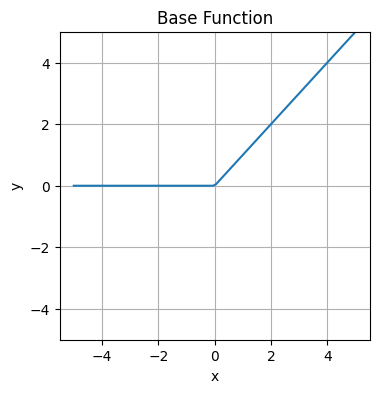

In [7]:
import torch
import matplotlib.pyplot as plt

def base(x):
    return torch.maximum(x, torch.tensor(0.0))

x = torch.linspace(-5, 5, 100)
y = base(x)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = ax.plot(x, y)
_ = ax.set_title("Base Function")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.set_ylim(-5, 5)
_ = ax.grid()

このままだとfitting しようにも動かせるパラメータがないので, このグラフを並行移動と縦横の拡大縮小ができるようにパラメータを加え, fitting 関数として定義します.

$\hat{f}(x \mid a_1, a_2, b_1, b_2) = a_1 f(a_2(x - b_1)) + b_2$

In [90]:
from ipywidgets import interact
import torch
import matplotlib.pyplot as plt


def f(x):
    return torch.maximum(x, torch.tensor(0.0))

def f_hat(x, a1, a2, b1, b2):
    return a2 * f(a1*(x - b1)) + b2

def plot(a1=1., a2=1., b1=0., b2=0.):
    x = torch.linspace(-5, 5, 100)
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111)
    _ = ax.plot(x, f_hat(x, a1, a2, b1, b2), color='red', linestyle='-')
    _ = ax.set_ylim(-5, 5)
    _ = ax.set_xlabel('x')
    _ = ax.set_ylabel('y')
    _ = ax.set_title(f'Base fitting function: a1={a1:.2f}, a2={a2:.2f}, b1={b1:.2f}, b2={b2:.2f}')
    _ = ax.grid()

_ = interact(plot, a1=(-5.0, 5.0, 0.1), a2=(-5.0, 5.0, 0.1), b1=(-5.0, 5.0, 0.1), b2=(-5.0, 5.0, 0.1))

interactive(children=(FloatSlider(value=1.0, description='a1', max=5.0, min=-5.0), FloatSlider(value=1.0, desc…

これで最小単位の部品が揃いました. 機械学習の文脈ではこの部品を**Neuron** (ニューロン)と呼びます. この命名の由来は後の章で説明しますので, 今は単にこの部品の名前として受け入れてください.

部品が整ったとはいえこんな単純な形の関数がどう役に立つのか全くピンとこないと思います.
上でも述べたようにNN はこの部品を「切り貼り」することで成立します. 以下ではこの「切り貼り」をどう行うのかを見ていきましょう.

> **_NOTE_** <details close><summary>Neuron という語の定義について</summary>
>
> このfitting関数をneuron として命名することの是非は大いに議論の余地あり.
> 関数に対する表現や操作と, 本来のニューロンそのもの同士の相互作用や機能で用語が重複しつつ実態に微妙に乖離がありように思えるので, もう少しうまく定式化したいところ.
>
> </details>

#### 1.3.1.2 ニューロンの足し合わせ

関数を貼り合わせる一番シンプルな方法は足し算です.

$$
\hat{f}(x \mid a_1, a_2, b_1, b_2) = \sum_{i=1}^n a_2^{(i)}f\left( a_1^{(i)}x + b_1^{(i)} \right) + b_2^{(i)}
$$

以下ではシンプルに, ニューロンを2つ足し合わせた場合に関数系がどのようになるかを観てみましょう.

In [91]:
from ipywidgets import FloatSlider, VBox, HBox, interactive_output

a11 = FloatSlider(value=0.5, min=-5.0, max=5.0, step=0.1, description="a11", readout_format=".1f")
a12 = FloatSlider(value=1., min=-5.0, max=5.0, step=0.1, description="a12", readout_format=".1f")
b11 = FloatSlider(value=0., min=-5.0, max=5.0, step=0.1, description="b11", readout_format=".1f")
b12 = FloatSlider(value=0., min=-5.0, max=5.0, step=0.1, description="b12", readout_format=".1f")

a21 = FloatSlider(value=0.5, min=-5.0, max=5.0, step=0.1, description="a21", readout_format=".1f")
a22 = FloatSlider(value=1., min=-5.0, max=5.0, step=0.1, description="a22", readout_format=".1f")
b21 = FloatSlider(value=2.5, min=-5.0, max=5.0, step=0.1, description="b21", readout_format=".1f")
b22 = FloatSlider(value=0., min=-5.0, max=5.0, step=0.1, description="b22", readout_format=".1f")

f1 = VBox([a11, a12, b11, b12])
f2 = VBox([a21, a22, b21, b22])
ui = HBox([f1, f2])

def plot(a11, a12, b11, b12,
         a21, a22, b21, b22):
    x = torch.linspace(-5, 5, 100)
    y1 = f_hat(x, a11, a12, b11, b12)
    y2 = f_hat(x, a21, a22, b21, b22)
    #
    ysum = y1 + y2
    fig = plt.figure(figsize=(6.5, 6.5))
    #
    ax1 = fig.add_subplot(221)
    _ = ax1.plot(x, y1, color='tab:blue', linestyle='-')
    _ = ax1.set_ylim(-5, 5)
    _ = ax1.set_xlabel('x')
    _ = ax1.set_ylabel('y')
    _ = ax1.set_title(f'First base function')
    _ = ax1.grid()
    #
    ax2 = fig.add_subplot(222)
    _ = ax2.plot(x, y2, color='tab:orange', linestyle='-')
    _ = ax2.set_ylim(-5, 5)
    _ = ax2.set_xlabel('x')
    _ = ax2.set_ylabel('y')
    _ = ax2.set_title(f'Second base function')
    _ = ax2.grid()
    #
    ax3 = fig.add_subplot(223)
    _ = ax3.plot(x, ysum, color='tab:green', linestyle='-')
    _ = ax3.set_ylim(-5, 5)
    _ = ax3.set_xlabel('x')
    _ = ax3.set_ylabel('y')
    _ = ax3.set_title(f'Sum of two base functions')
    _ = ax3.grid()

out = interactive_output(plot, {'a11': a11, 'a12': a12, 'b11': b11, 'b12': b12,
                               'a21': a21, 'a22': a22, 'b21': b21, 'b22': b22})
display(ui, out)

Output()

ご覧のように, ニューロンを足し合わせると折れ線を継ぎはぎしたような形になります.
また直観通り, ニューロンの数を増やすことはそのまま折れ線の折れ目を増やすことに対応しています.
そのため原則として, 足し合わせるニューロンの数を増やすことでより複雑な関数を表現できるようになります.

#### 1.3.1.3 ニューロンの足し合わせによるfitting

ここでは具体的なデータセットを用意して, ニューロンの足し合わせによるfitting を実際に見てみましょう.

データセットとしては以下を用意しました.

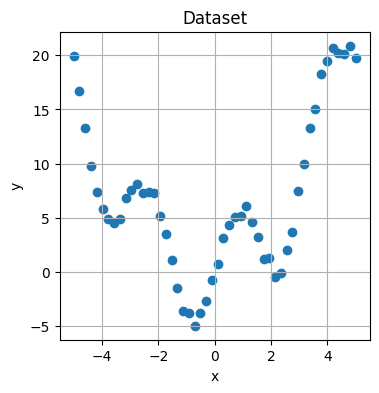

In [3]:
import torch
import matplotlib.pyplot as plt

dataset = torch.tensor([
        [-5.0000, 19.9753],
        [-4.7959, 16.6626],
        [-4.5918, 13.3273],
        [-4.3878,  9.8200],
        [-4.1837,  7.4106],
        [-3.9796,  5.8454],
        [-3.7755,  4.8899],
        [-3.5714,  4.5567],
        [-3.3673,  4.8462],
        [-3.1633,  6.7783],
        [-2.9592,  7.6026],
        [-2.7551,  8.1018],
        [-2.5510,  7.3079],
        [-2.3469,  7.3507],
        [-2.1429,  7.2832],
        [-1.9388,  5.1307],
        [-1.7347,  3.5130],
        [-1.5306,  1.0557],
        [-1.3265, -1.5252],
        [-1.1224, -3.5944],
        [-0.9184, -3.8076],
        [-0.7143, -4.9773],
        [-0.5102, -3.7722],
        [-0.3061, -2.6819],
        [-0.1020, -0.7651],
        [ 0.1020,  0.7249],
        [ 0.3061,  3.1635],
        [ 0.5102,  4.3074],
        [ 0.7143,  5.0760],
        [ 0.9184,  5.1199],
        [ 1.1224,  6.0594],
        [ 1.3265,  4.5782],
        [ 1.5306,  3.2450],
        [ 1.7347,  1.2015],
        [ 1.9388,  1.2859],
        [ 2.1429, -0.4761],
        [ 2.3469, -0.1454],
        [ 2.5510,  1.9991],
        [ 2.7551,  3.6881],
        [ 2.9592,  7.4508],
        [ 3.1633,  9.9941],
        [ 3.3673, 13.3236],
        [ 3.5714, 15.0379],
        [ 3.7755, 18.2563],
        [ 3.9796, 19.4761],
        [ 4.1837, 20.6810],
        [ 4.3878, 20.2311],
        [ 4.5918, 20.0776],
        [ 4.7959, 20.8873],
        [ 5.0000, 19.7803]])

x = dataset[:, 0]
y = dataset[:, 1]

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = ax.scatter(x, y)
_ = ax.set_title("Dataset")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.grid()

> **_NOTE_** <details close><summary>目的関数の正解</summary>
> $y = 5 \sin(2x) + 0.5x + 0.8x^2 + \epsilon, ~ \epsilon \sim \mathrm{N}(0, 0.5)$
> </details>

実際のfitting を行うコードは省略して, ここではfitting の結果だけを示します.
ここでは, ニューロンを5つ足し合わせてfitting を行いました.

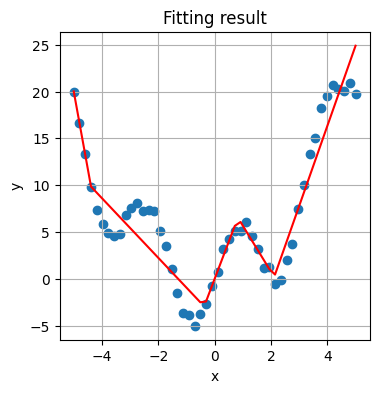

In [84]:
n_neuron = 5

def f(x):
    return torch.maximum(x, torch.tensor(0.0))

def f_hat(x, a1, a2, b1, b2):
    return a2 * f(a1*x + b1) + b2

def fit_f(x, a1, b1, a2, b2):
    y_hat = 0
    for i in range(n_neuron):
        y_hat += f_hat(x, a1[i], a2[i], b1[i], b2[i])
    return y_hat

theta = torch.tensor([
        [3.4336722, -2.651572, 3.167959, 3.3171465, -0.7376518],
        [-7.254289, -1.0960692, 1.1251626, -2.736918, -3.2360973],
        [3.917879, 1.1994565, 2.494343, -3.8627312, 18.140102],
        [-0.07787375, -0.24835609, -0.6120783, -0.2764072, -1.5676818],
    ])

x = dataset[:, 0]
y = dataset[:, 1]
y_hat = fit_f(x, theta[0], theta[1], theta[2], theta[3]).numpy()

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = ax.scatter(x, y)
_ = ax.plot(x, y_hat, color='red', linestyle='-')
_ = ax.set_title("Fitting result")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.grid()

かなり大雑把ですが, 単純な折れ線の組み合わせとしては悪くない近似になっています.
続いて最終的な関数の形が, どのようにひとつひとつのニューロンによって作られているのかを見てみましょう.

以下の例ではスライダーのn を大きくしてくと, 順にニューロンが足されていきます. オレンジ色のグラフが新しく追加されたニューロンのグラフ, 赤いグラフは追加されたニューロンの合計です.
グラフの右に表示されているのが, その時点での関数の実際の数値表現です.

In [87]:
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact

theta = torch.tensor([
        [3.4336722, -2.651572, 3.167959, 3.3171465, -0.7376518],
        [-7.254289, -1.0960692, 1.1251626, -2.736918, -3.2360973],
        [3.917879, 1.1994565, 2.494343, -3.8627312, 18.140102],
        [-0.07787375, -0.24835609, -0.6120783, -0.2764072, -1.5676818],
    ])
n_neuron = 5

def sum_until_nth(x, n):
    a1 = theta[0]
    b1 = theta[1]
    a2 = theta[2]
    b2 = theta[3]
    #
    x = a1[:n, None] * x + b1[:n, None]
    x = f(x)
    x = a2[:n, None] * x + b2[:n, None]
    x = x.sum(dim=0)
    return x

def plot(n=1):
    x = dataset[:, 0]
    y = dataset[:, 1]
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(121)
    _ = ax.plot(x, sum_until_nth(x, n).detach().numpy(), color='red', linestyle='-')
    for i in range(n):
        y_hat = theta[0][i] * x + theta[1][i]
        y_hat = f(y_hat)
        y_hat = theta[2][i] * y_hat + theta[3][i]
        c = 'tab:orange' if i == (n-1) else 'tab:blue'
        a = 1.0 if i == (n-1) else 0.5
        _ = ax.plot(x, y_hat, color=c, linestyle='-', alpha=a)
    _ = ax.scatter(x, y)
    _ = ax.set_xlabel('x')
    _ = ax.set_ylabel('y')
    _ = ax.set_ylim(-7, 22)
    _ = ax.set_title(f'Combination of {n} neurons')
    _ = ax.grid()

    ax2 = fig.add_subplot(122)
    expr_to_show = ""
    for i in range(n):
        if i == 0:
            expr_to_show += r"$y = "
        else:
            expr_to_show += r"     $"
        expr_to_show += fr"{theta[2][i]:+.2f} \times f~({theta[0][i]:.2f}x {theta[1][i]:+.2f}) {theta[3][i]:+.2f}$"
        expr_to_show += "\n"
    _ = ax2.text(
        0.05, 0.8, expr_to_show,
        horizontalalignment='left',
        verticalalignment='top',
        fontsize=11,
        transform=ax2.transAxes,
        wrap=True,
    )
    # turn off the axis
    _ = ax2.axis('off')

_ = interact(plot, n=(1, n_neuron, 1))

interactive(children=(IntSlider(value=1, description='n', max=5, min=1), Output()), _dom_classes=('widget-inte…

#### 1.3.1.4 関数の合成によるニューロンの貼り合わせ

ニューロンを貼り合わせるもうひとつの方法は関数の合成です. ここでいう関数の合成というのは, いわゆる以下で表されるやつです.
$$ (g \circ f)(x) = g(f(x))$$

足し算のときと同様に, まずは2つのニューロンを合成した際にどうなるかを具体的に見ていきましょう.

In [94]:
from ipywidgets import FloatSlider, VBox, HBox, interactive_output

a11 = FloatSlider(value=1., min=-5.0, max=5.0, step=0.1, description="a11", readout_format=".1f")
a12 = FloatSlider(value=1., min=-5.0, max=5.0, step=0.1, description="a12", readout_format=".1f")
b11 = FloatSlider(value=0., min=-5.0, max=5.0, step=0.1, description="b11", readout_format=".1f")
b12 = FloatSlider(value=0., min=-5.0, max=5.0, step=0.1, description="b12", readout_format=".1f")

a21 = FloatSlider(value=-1., min=-5.0, max=5.0, step=0.1, description="a21", readout_format=".1f")
a22 = FloatSlider(value=1., min=-5.0, max=5.0, step=0.1, description="a22", readout_format=".1f")
b21 = FloatSlider(value=2.5, min=-5.0, max=5.0, step=0.1, description="b21", readout_format=".1f")
b22 = FloatSlider(value=0., min=-5.0, max=5.0, step=0.1, description="b22", readout_format=".1f")

f1 = VBox([a11, a12, b11, b12])
f2 = VBox([a21, a22, b21, b22])
ui = HBox([f1, f2])

def f(x):
    return torch.maximum(x, torch.tensor(0.0))

def f_hat(x, a1, a2, b1, b2):
    return a2 * f(a1*(x - b1)) + b2

def plot(a11, a12, b11, b12,
         a21, a22, b21, b22):
    x = torch.linspace(-5, 5, 100)
    y1 = f_hat(x, a11, a12, b11, b12)
    y2 = f_hat(x, a21, a22, b21, b22)
    #
    ysum = f_hat(y1, a21, a22, b21, b22)
    fig = plt.figure(figsize=(6.5, 6.5))
    #
    ax1 = fig.add_subplot(221)
    _ = ax1.plot(x, y1, color='tab:blue', linestyle='-')
    _ = ax1.set_ylim(-5, 5)
    _ = ax1.set_xlabel('x')
    _ = ax1.set_ylabel('y')
    _ = ax1.set_title(f'First base function')
    _ = ax1.grid()
    #
    ax2 = fig.add_subplot(222)
    _ = ax2.plot(x, y2, color='tab:orange', linestyle='-')
    _ = ax2.set_ylim(-5, 5)
    _ = ax2.set_xlabel('x')
    _ = ax2.set_ylabel('y')
    _ = ax2.set_title(f'Second base function')
    _ = ax2.grid()
    #
    ax3 = fig.add_subplot(223)
    _ = ax3.plot(x, ysum, color='tab:green', linestyle='-')
    _ = ax3.set_ylim(-5, 5)
    _ = ax3.set_xlabel('x')
    _ = ax3.set_ylabel('y')
    _ = ax3.set_title(f'Sum of two base functions')
    _ = ax3.grid()

out = interactive_output(plot, {'a11': a11, 'a12': a12, 'b11': b11, 'b12': b12,
                               'a21': a21, 'a22': a22, 'b21': b21, 'b22': b22})
display(ui, out)

Output()

足し算の時とは違い, ある程度いじってもあまり直観的に分からないかもしれません.
ここでは2つのニューロンのみを合成しましたが, 実際に関数の合成が効果的に機能するのは先ほどの足し算と併用したときです.

試しに先ほどの5つのニューロンで作ったfitting 関数を2つ用意して合成したものでfitting した結果を見てみましょう.

#### 1.3.1.5 関数の合成によるfitting

データセットには先ほどと同じものを使い, 先ほど同様ここではfitting の結果だけを示します.

Epoch 0, Loss: 1.7538335621356964, LR: 4.50e-03


Epoch 1000, Loss: 1.181147813796997, LR: 4.05e-03
Epoch 2000, Loss: 1.1097761988639832, LR: 3.65e-03
Epoch 3000, Loss: 1.0953270196914673, LR: 3.28e-03
Epoch 4000, Loss: 1.0857149362564087, LR: 2.95e-03
Epoch 5000, Loss: 1.0692751109600067, LR: 2.66e-03
Epoch 6000, Loss: 1.0847526788711548, LR: 2.39e-03
Epoch 7000, Loss: 1.0924837589263916, LR: 2.15e-03
Epoch 8000, Loss: 1.0800910592079163, LR: 1.94e-03
Epoch 9000, Loss: 1.0784696340560913, LR: 1.74e-03
a: array([[ 2.277565  ,  2.0818648 , -2.091385  ,  2.2894485 ],
       [-1.6214972 , -2.006442  , -1.2724243 , -1.7373123 ],
       [-2.251937  ,  2.5622828 ,  1.0566335 , -2.7065961 ],
       [-2.7508798 , -3.0715334 , -0.07248084,  0.13563994],
       [-0.9031626 ,  1.2331655 ,  0.76850045,  3.7941828 ]],
      dtype=float32)
b: array([[ -0.64992124,  -1.3103541 ,   3.0604284 , -11.124007  ],
       [  1.7783631 ,  -1.3557833 ,  -8.274943  , -10.606683  ],
       [  5.0640893 ,  -2.276254  , -11.374386  , -10.939752  ],
       [  0.57

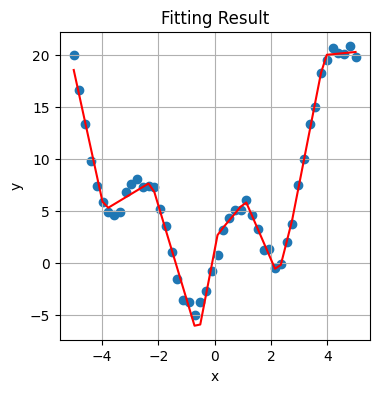

In [149]:
import torch.optim as optim

n_neuron = 5
n_layer = 2

theta = torch.tensor([
        [3.4336722, -2.651572, 3.167959, 3.3171465, -0.7376518],
        [-7.254289, -1.0960692, 1.1251626, -2.736918, -3.2360973],
        [3.917879, 1.1994565, 2.494343, -3.8627312, 18.140102],
        [-0.07787375, -0.24835609, -0.6120783, -0.2764072, -1.5676818],
    ])
'''
a = torch.randn((n_neuron, n_layer*2), requires_grad=True)
b = torch.randn((n_neuron, n_layer*2), requires_grad=True)
# a1 = torch.randn(n_neuron, requires_grad=True)
# b1 = torch.randn(n_neuron, requires_grad=True)
# a2 = torch.randn(n_neuron, requires_grad=True)
# b2 = torch.randn(n_neuron, requires_grad=True)
#'''
if False:
    with torch.no_grad():
        a[:, 0] = theta[0]
        b[:, 0] = theta[1]
        a[:, 1] = theta[2]
        b[:, 1] = theta[3]
        a[:, -1] = 1.0
        b[:, -1] = 0.0

def f(x):
    return torch.maximum(x, torch.tensor(0.0))

def f_hat(x, a1, a2, b1, b2):
    return a2 * f(a1*x + b1) + b2

def fit_f(x, a1, b1, a2, b2):
    y_hat = 0
    for i in range(n_neuron):
        y_hat += f_hat(x, a1[i], a2[i], b1[i], b2[i])
    return y_hat

def combined(x):
    for i in range(0, n_layer*2, 2):
        x = a[:, i, None] * x + b[:, i, None]
        x = f(x)
        x = a[:, i+1, None] * x + b[:, i+1, None]
        x = x.sum(dim=0)
    return x

loss_fn = torch.nn.MSELoss()
optimizer = optim.Adam([a, b], lr=5e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

batch_size = 25
for epoch in range(10_000):
    idx = torch.randperm(x.shape[0])
    x_sort = x[idx]
    y_sort = y[idx]
    losses = []
    for i in range(0, x.shape[0], batch_size):
        x_batch = x_sort[i:i+batch_size]
        y_batch = y_sort[i:i+batch_size]
        #
        optimizer.zero_grad()
        y_hat = combined(x_batch)
        loss = loss_fn(y_hat, y_batch)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if epoch % 1000 == 0:
        scheduler.step()
        print(f"Epoch {epoch}, Loss: {sum(losses)}, LR: {scheduler.get_last_lr()[0]:.2e}")

y_pred = combined(x)

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
_ = ax.scatter(x, y)
_ = ax.plot(x, y_pred.detach().numpy(), color='red', linestyle='-')
_ = ax.set_title("Fitting Result")
_ = ax.set_xlabel("x")
_ = ax.set_ylabel("y")
_ = ax.grid()

print(f"a: {repr(a.detach().numpy())}")
print(f"b: {repr(b.detach().numpy())}")

In [ ]:
a = np.array([[ 2.277565  ,  2.0818648 , -2.091385  ,  2.2894485 ],
       [-1.6214972 , -2.006442  , -1.2724243 , -1.7373123 ],
       [-2.251937  ,  2.5622828 ,  1.0566335 , -2.7065961 ],
       [-2.7508798 , -3.0715334 , -0.07248084,  0.13563994],
       [-0.9031626 ,  1.2331655 ,  0.76850045,  3.7941828 ]],
      dtype=np.float32)
b =  np.array([[ -0.64992124,  -1.3103541 ,   3.0604284 , -11.124007  ],
       [  1.7783631 ,  -1.3557833 ,  -8.274943  , -10.606683  ],
       [  5.0640893 ,  -2.276254  , -11.374386  , -10.939752  ],
       [  0.57186085,  -0.94168013,  -2.5660074 , -10.980584  ],
       [  2.4720242 ,  -0.48419482,  11.169371  , -10.121333  ]],
      dtype=np.float32)

In [79]:
theta = torch.stack([a1, b1, a2, b2], dim=0).detach()
if False or True:
    theta[2][1] = 1.2
    theta[0][4] = -1.0
    theta[1][4] = -4.0
    theta[2][4] = 25.0

def sum_until_nth(x, n):
    a1 = theta[0]
    b1 = theta[1]
    a2 = theta[2]
    b2 = theta[3]
    #
    x = a1[:n, None] * x + b1[:n, None]
    x = f(x)
    x = a2[:n, None] * x + b2[:n, None]
    x = x.sum(dim=0)
    return x

def plot(n=1):
    x = dataset[:, 0]
    y = dataset[:, 1]
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(121)
    _ = ax.plot(x, sum_until_nth(x, n).detach().numpy(), color='red', linestyle='-')
    for i in range(n):
        y_hat = theta[0][i] * x + theta[1][i]
        y_hat = f(y_hat)
        y_hat = theta[2][i] * y_hat + theta[3][i]
        c = 'tab:orange' if i == (n-1) else 'gray'
        a = 0.6 if i == (n-1) else 0.5
        _ = ax.plot(x, y_hat, color=c, linestyle='-', alpha=a)
    _ = ax.scatter(x, y)
    _ = ax.set_xlabel('x')
    _ = ax.set_ylabel('y')
    _ = ax.set_ylim(-7, 22)
    _ = ax.set_title(f'Combination of {n} neurons')
    _ = ax.grid()

    ax2 = fig.add_subplot(122)
    expr_to_show = ""
    for i in range(n):
        if i == 0:
            expr_to_show += r"$y = "
        else:
            expr_to_show += r"     $"
        expr_to_show += fr"{theta[2][i]:+.2f} \times f~({theta[0][i]:.2f}x {theta[1][i]:+.2f}) {theta[3][i]:+.2f}$"
        expr_to_show += "\n"
    _ = ax2.text(
        0.05, 0.8, expr_to_show,
        horizontalalignment='left',
        verticalalignment='top',
        fontsize=11,
        transform=ax2.transAxes,
        wrap=True,
    )
    # turn off the axis
    _ = ax2.axis('off')

_ = interact(plot, n=(1, n_neuron, 1))

interactive(children=(IntSlider(value=1, description='n', max=5, min=1), Output()), _dom_classes=('widget-inte…